## Sentiment Based Product Recommendation System

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

- Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model
- Deploying the end-to-end project with a user interface

##### Importing required libraries

In [68]:
import numpy as np
import pandas as pd
import re
import io
import string
from autocorrect import Speller
import swifter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics.pairwise import pairwise_distances

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn import metrics

import pickle

import en_core_web_sm
nlp = en_core_web_sm.load()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

### Sentiment Analysis

NLP pipeline that I will be following:
1.  Data loading
2. Text preprocessing
3. Exploratory data analysis (EDA)
4. Feature extraction
5. Model building using 4 classification algorithms
6. Model training and evaluation
7. Select best performing model and proceed with hyper-parameter tuning
8. Serialize the final model

##### Loading the data from CSV

In [2]:
df = pd.read_csv('capstone_data.csv')


df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


##### Basic Inspection

In [3]:
#Checking the size of the dataset 

df.shape

(30000, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
#Checking the percentage of missing values in the columns

((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
id                       0.00
brand                    0.00
categories               0.00
name                     0.00
reviews_rating           0.00
reviews_text             0.00
user_sentiment           0.00
dtype: float64

In [6]:
#Checking the unique entries in the columns

df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [7]:
# Checking the positive-negative review count in user_sentiment column

df.user_sentiment.value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [8]:
# Checking the positive-negative review count in user_sentiment column

df.reviews_title.value_counts()

Great Product                       384
Great movie                         361
Clorox Wipes                        278
Great                               221
Great product                       205
                                   ... 
Keeping them healthy!                 1
Fighting Power                        1
great all together                    1
Great Product and Easy to Use...      1
Conditioned into healthy              1
Name: reviews_title, Length: 18535, dtype: int64

In [9]:
df.dropna(subset=['user_sentiment'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29999 non-null  object
 1   brand                 29999 non-null  object
 2   categories            29999 non-null  object
 3   manufacturer          29858 non-null  object
 4   name                  29999 non-null  object
 5   reviews_date          29953 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27429 non-null  object
 8   reviews_rating        29999 non-null  int64 
 9   reviews_text          29999 non-null  object
 10  reviews_title         29809 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  169 non-null    object
 13  reviews_username      29936 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

##### Explorartory Data Analysis



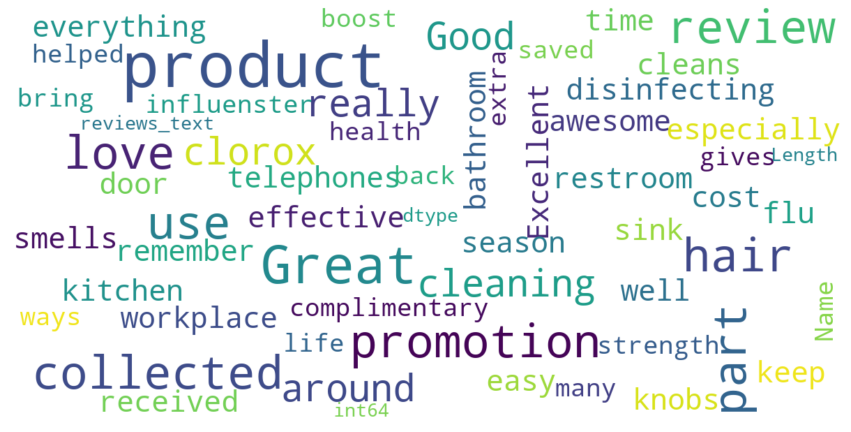

In [11]:
# Lets plot some wordclouds

stopword = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopword, max_words=300, max_font_size=30,
                     scale=3, random_state=1).generate(str(df['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
       

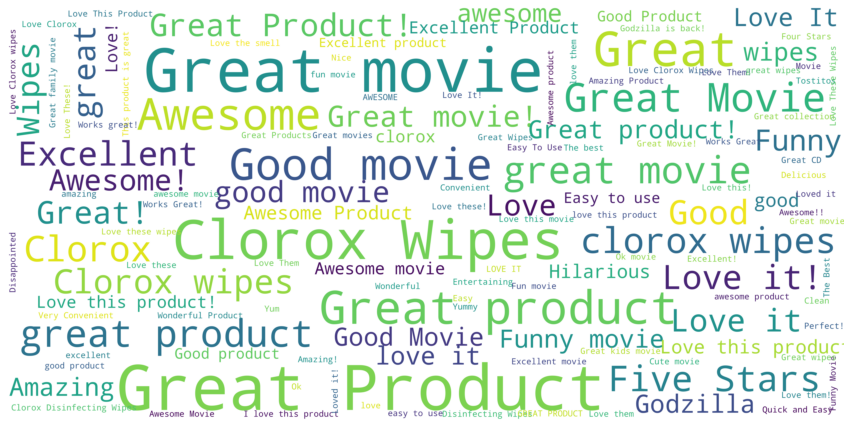

In [12]:
wordcloud = WordCloud(background_color='white', stopwords=stopword, max_words=400, max_font_size=
                     30, scale=30, random_state=1).generate_from_frequencies((df['reviews_title'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

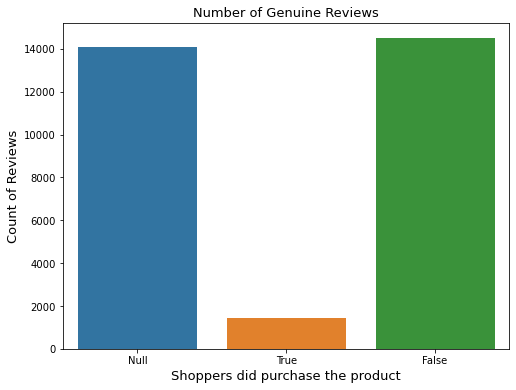

In [13]:
df['reviews_didPurchase'].fillna('Null', inplace=True)

plt.figure(figsize=(8,6))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=13)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=13)
ax.axes.set_title('Number of Genuine Reviews', fontsize=13)
ax.tick_params(labelsize=10)

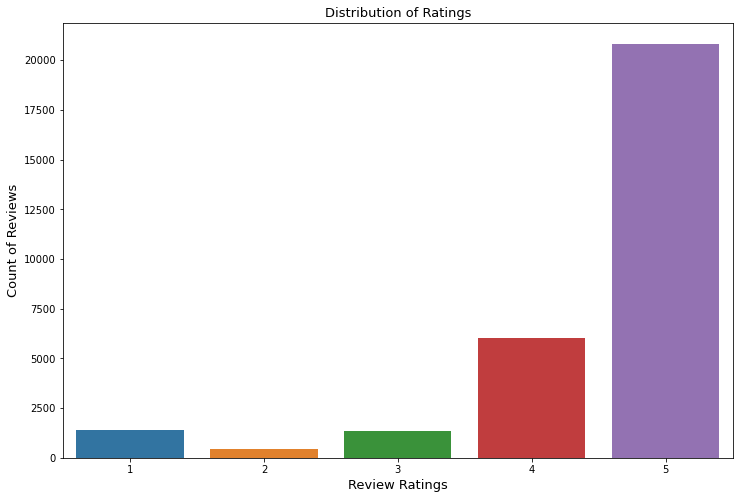

In [14]:
plt.figure(figsize=(12,8))
ax = sns.countplot(df['reviews_rating'])
ax.set_xlabel(xlabel="Review Ratings", fontsize=13)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=13)
ax.axes.set_title('Distribution of Ratings', fontsize=13)
ax.tick_params(labelsize=10)

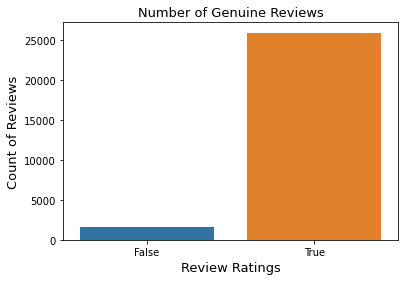

In [15]:
ax = sns.countplot(df['reviews_doRecommend'])
ax.set_xlabel(xlabel="Review Ratings", fontsize=13)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=13)
ax.axes.set_title('Number of Genuine Reviews', fontsize=13)
ax.tick_params(labelsize=10)

##### Feature Extraction

In [16]:
# First, lets segregate the train and test columns

X = df['reviews_text']
y = df['user_sentiment'].map({'Positive': 1, 'Negative': '0'})

In [17]:
# Creating some functions for preprocessing

import nltk
from nltk.corpus import stopwords

LEMMATIZER = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
spell = Speller()

def clean_text(text):
    # converting the text to lowercase
    text = text.lower()  
    
    # keeping only alphabets
    text = re.sub(r'[^A-Za-z ]+', '', text) 

    # removing emojis
    emoji = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji.sub(r'',text)

    #removing punctutions
    punctuations = str.maketrans("","", string.punctuation)
    text = text.translate(punctuations)

    return text


# A function to lemmatize the text
def lemmatize_text(text):  
    word_tokens = word_tokenize(text)    
    tokens = [LEMMATIZER.lemmatize(word) for word in word_tokens if not word in STOPWORDS]
    return " ".join(tokens)
 




In [18]:
#Applying the functions to clean and lemmatize the data

df['reviews_text'] = df['reviews_text'].swifter.apply(lambda x : clean_text(x))
df['reviews_text'] = df['reviews_text'].swifter.apply(lambda x : lemmatize_text(x))
df['reviews_text'][1]

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

'good flavor review collected part promotion'

In [19]:
# Splitting the data in train and test samples before vectorizing them

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [20]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (23999,)
X_test shape:  (6000,)
Y_train shape:  (23999,)
Y_test shape:  (6000,)


In [21]:
# TF-IDF Vectorization

TF_IDF = TfidfVectorizer(max_features=13000, lowercase=True, analyzer='word', stop_words= 'english')


X_train = TF_IDF.fit_transform(X_train)
X_test = TF_IDF.transform(X_test)

In [22]:
# Serializing the vectorizer to use in main python file for sentiment prediction of revieews text

with open('vectorizer.pkl', 'wb') as fin:
     pickle.dump(TF_IDF, fin)

In [23]:
print(y_train)

21753    0
251      1
22941    0
618      1
17090    1
        ..
29803    1
5390     0
860      1
15795    1
23654    1
Name: user_sentiment, Length: 23999, dtype: object


##### Modelling

We will be fitting four models as mentioned in the problem statement:
1. Logistic Regression
2. Random Forest Classifier
3. Naive Bayes Classifier: MultinomialNB
4. Stochastic Gradient Descent Classifier

In [24]:
# First, Lets create a dataframe that keep record of all the model and their performances


score_df = pd.DataFrame({"Model":[None],"Accuracy":[None],"Precision":[None],"Sensitivity":[None],"Specificity":[None]})

In [25]:
#Lets create a function to train & evaluate different algorithms 

def train_eval_model(X, y, model_name, x_test, y_test, score_df):
  """
  params:
    X : Train data 
    y : Train Label
    model_name : the model that you need to train
    x_test: Test Data
    y_test: Test Label
    score_df: dataframe to keep track of all the model and their performance you trained
  
  """
  #Fitting the model and predicting
  y = y.astype(int)
  model = model_name().fit(X, y)
  model_pred = model.predict(x_test)

  #accuracy = model.score(X_test, y_test)
  model_performance = metrics.confusion_matrix(y_test.astype(int), model_pred)


  TP = model_performance[1,1]  
  TN = model_performance[0,0] 
  FP = model_performance[0,1] 
  FN = model_performance[1,0]

  #Accuracy
  accuracy = float((TP+TN)/(TP+FN+TN+FP))

  #Preccison
  pre = float(TP/(TP+FP))

  # Sensitivity
  sens = float(TP /(TP+FN))
      
  # Specificity
  spec = float(TN / (TN+FP))


  return pd.DataFrame({"Model":[model_name],"Accuracy":[accuracy],"Precision":[pre],"Sensitivity":[sens], "Specificity":[spec]})
    
  



In [26]:
# Fitting Logistic Regression

df_temp = train_eval_model(X_train, y_train, LogisticRegression, X_test, y_test, score_df)
score_df.dropna(inplace=True)
score_df = score_df.append(df_temp, ignore_index=True)
score_df

,Model,Accuracy,Precision,Sensitivity,Specificity
0,<class 'sklearn.linear_model._logistic.Logisti...,0.915667,0.91841,0.993641,0.277182


In [27]:
# Fitting Random Forest Classifier

df_temp = train_eval_model(X_train, y_train, RandomForestClassifier, X_test, y_test, score_df)
score_df = score_df.append(df_temp, ignore_index=True)
score_df

,Model,Accuracy,Precision,Sensitivity,Specificity
0,<class 'sklearn.linear_model._logistic.Logisti...,0.915667,0.918410,0.993641,0.277182
1,<class 'sklearn.ensemble._forest.RandomForestC...,0.925000,0.926642,0.994576,0.355283


In [28]:
# Fitting Naive Bayes: MultinomialNB

df_temp = train_eval_model(X_train, y_train, MultinomialNB, X_test, y_test, score_df)
score_df = score_df.append(df_temp, ignore_index=True)
score_df

,Model,Accuracy,Precision,Sensitivity,Specificity
0,<class 'sklearn.linear_model._logistic.Logisti...,0.915667,0.918410,0.993641,0.277182
1,<class 'sklearn.ensemble._forest.RandomForestC...,0.925000,0.926642,0.994576,0.355283
2,<class 'sklearn.naive_bayes.MultinomialNB'>,0.891333,0.891315,1.000000,0.001531


In [29]:
# Fitting Stochastic Gradient Descent Classifier

df_temp = train_eval_model(X_train, y_train, SGDClassifier, X_test, y_test, score_df)
score_df = score_df.append(df_temp, ignore_index=True)
score_df

,Model,Accuracy,Precision,Sensitivity,Specificity
0,<class 'sklearn.linear_model._logistic.Logisti...,0.915667,0.918410,0.993641,0.277182
1,<class 'sklearn.ensemble._forest.RandomForestC...,0.925000,0.926642,0.994576,0.355283
2,<class 'sklearn.naive_bayes.MultinomialNB'>,0.891333,0.891315,1.000000,0.001531
3,<class 'sklearn.linear_model._stochastic_gradi...,0.912167,0.913379,0.995886,0.226646


In [30]:
#Since RandomForest is our best performer among all the 4 model, we will proceed with the hypertuning it.

y_train = y_train.astype(int)

rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train, y_train)

cv_results = cross_validate(rf_final, X_train, y_train, cv=3, scoring=["accuracy", "f1", "roc_auc"])


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [43]:
cv_results

{'fit_time': array([14.15354514, 13.92859888, 15.01338482]),
 'score_time': array([0.65890503, 0.64485407, 0.68001604]),
 'test_accuracy': array([0.914     , 0.915125  , 0.91398925]),
 'test_f1': array([0.95341278, 0.95397546, 0.9534254 ]),
 'test_roc_auc': array([0.93272525, 0.94186802, 0.93860542])}

In [44]:
# Lets check best parameters

rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [45]:
# Training our final model: Fitting Random Forest Classifier Model with best parameters that we obtained in last step

y_train = y_train.astype(int)
rf_final = rf_model.set_params(max_depth= None, max_features= 'auto', min_samples_split= 2, 
                               n_estimators= 100, random_state=17).fit(X_train, y_train)

In [46]:
cv_results = cross_validate(rf_final, X_train, y_train, cv=3, scoring=["accuracy", "f1", "roc_auc"])

In [47]:
cv_results

{'fit_time': array([14.03925085, 13.69706392, 14.24456429]),
 'score_time': array([0.651299  , 0.63165522, 0.66323471]),
 'test_accuracy': array([0.914     , 0.915125  , 0.91398925]),
 'test_f1': array([0.95341278, 0.95397546, 0.9534254 ]),
 'test_roc_auc': array([0.93272525, 0.94186802, 0.93860542])}

In [48]:
# Lets take an observation to see the performance of our model

random_review = pd.Series(df["reviews_text"].sample(1).values)
random_review

0    regular user conditioner glad got opportunity ...
dtype: object

In [49]:
# Predicting the sentiment of the observation we took in last step

inp_data = TF_IDF.transform(random_review)

rf_final.predict(inp_data)

array([1])

In [39]:
# Pickeling our model for it will be used in main python app

filename = 'sentiment_analysis_model.pkl'
pickle.dump(rf_final, open(filename, 'wb'))

### Recommendation System

We will be using the Collaborative approach for building recommendation system as mentioned in the problem statement.

Collaborative filtering approaches:

    1. User-User based collaborative filtering
    2. Item-Item based collaborative filtering

In [69]:
# Reading data for recommendation System

df = pd.read_csv("capstone_data.csv", encoding='utf8')
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [70]:
#Lets fetch out the columns required for creating similarity matrices

df_main = df[['id', 'reviews_username', 'reviews_rating']]

In [71]:
#Renaming the columns for ease of understanding and coding

df_main = df_main.rename(columns= {'id':"product_id", 'reviews_username':"user", 'reviews_rating':"ratings"})

In [72]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  30000 non-null  object
 1   user        29937 non-null  object
 2   ratings     30000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [73]:
#Lets find the users who have given review to more than one product

print("Users who have given reviews to more than one product: ", 29937-(df_main.user.nunique()))

Users who have given reviews to more than one product:  5023


In [74]:
#Checking the descriptive stats of he rating column

df_main.ratings.describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

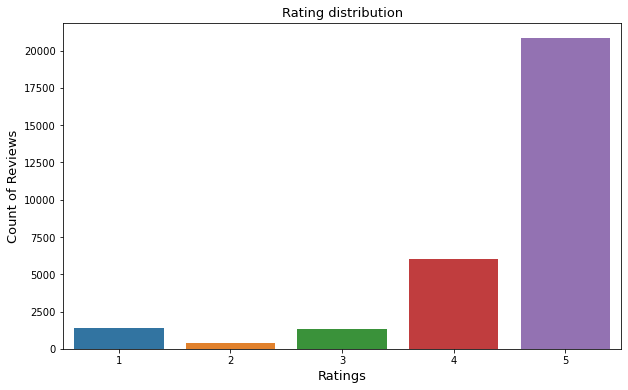

In [75]:
#Lets plot the distribution of user ratings

plt.figure(figsize=(10,6))
ax = sns.countplot(df_main['ratings'])
ax.set_xlabel(xlabel="Ratings", fontsize=13)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=13)
ax.axes.set_title('Rating distribution', fontsize=13)
ax.tick_params(labelsize=10)

##### Splitting the data into train and test for Recommendation System

In [76]:
#Lets split the data into train and test before jumping into building different type of matrices required for recommendation.

train, test = train_test_split(df_main, test_size=0.30, random_state=42)

In [77]:
#Lets check the dimensions of our train and test dataset

print("Shape of train dataset: ", train.shape)
print("Shape of test dataset: ", test.shape)

Shape of train dataset:  (21000, 3)
Shape of test dataset:  (9000, 3)


In [78]:
#Lets create a pivot table for user vs product rating to get a basic idea

df_pivot = train.pivot_table(
    index = 'user',
    columns = "product_id",
    values = 'ratings'
).fillna(0)

df_pivot

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

As we can see, the ‘df_pivot’ dataframe contains the column header with product id, the row header/index with user id, and the values with the corresponding ratings given by the user corresponding to the products.

##### Creating dummy train & dummy test dataset

In the process of building a recommendation system, we do not want to recommend a product that the user has already rated or in some cases has performed some action on it such as view, like, share or comment. To eliminate these products from the recommendation list, you will need to take the help of a ‘dummy data set’.

Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [79]:
# Creating the dummy_train dataset
# 1. take a copy of train data in a new df
# 2. The products not rated by user is marked as 1 
# 3. Convert the dummy train dataset into matrix format


dummy_train = train.copy()

dummy_train['ratings'] = dummy_train['ratings'].apply(lambda x: 0 if x>=1 else 1)

dummy_train = dummy_train.pivot_table(
    index='user',
    columns='product_id',
    values='ratings'
).fillna(1)

dummy_train

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

Now we need to create user similarity matrix for which we will be using pairwise_distance. We will use the following two approaches:

a. Cosine Similarity

b. Adjusted Cosine Similarity

In [80]:
# Creating the User Similarity Matrix using pairwise_distance function and metric will be COSINE.

user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [81]:
#Lets check shape of our user similarity matrix

user_correlation.shape

(18213, 18213)

In [82]:
# Now lets create a user similarity matrix with Adjusted Cosine Similarity approach

""" 
- Here we will be needing NaNs as we will first first find the mean which will store the values of means corresponding to each 
  product_id in the dataset for all the users 

- Once we have the mean array, we need to subtract each user's rating from the mean [for this we will be creating a new pivot table 
  ‘df_subtracted’ using ‘df_subtracted = (df_pivot.T-mean).T](Normalizing the user rating around mean 0)

- The ‘df_pivot’ has users in rows and products in columns, and you need to subtract each column from the data available in the 
  ‘mean’ array (1D array), and this is why you need to do ‘df_pivot.T’

- Then finally we  need to transpose the (df_pivot.T - mean) to finally get ‘df_substracted’
      
"""

df_pivot = train.pivot_table(
    index='user',
    columns='product_id',
    values='ratings'
)

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

In [83]:
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### Predictions: User-User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [84]:
user_correlation[user_correlation<0]=0

#getting predictions for the movies rated and not rated by the user
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))

In [85]:
# Lets get final pivot 

user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

In [86]:
user_final_rating_df = pd.DataFrame(user_final_rating)
user_final_rating_df

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

##### Finding the top 20 recommendation for the *user*

In [87]:
# Take the user ID as input.
#user_input = input("Enter your user name")
#print(user_input)
user_input = '01impala'

In [88]:
#Creating a new dataframe for recommendation

d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

product_id
AV13O1A8GV-KLJ3akUyj    0.0
AVpfPPkEilAPnD_xX3cP    0.0
AVpfMpZ51cnluZ0-f_L9    0.0
AVpfN6Z71cnluZ0-gZmO    0.0
AVpfNVsj1cnluZ0-gNQN    0.0
AVpfNWbPilAPnD_xXPR7    0.0
AVpfNc9cLJeJML434tza    0.0
AVpfNfEMLJeJML434uf-    0.0
AVpfNglu1cnluZ0-gQ7x    0.0
AVpfO5u71cnluZ0-guiN    0.0
AVpfOIrkilAPnD_xXgDG    0.0
AVpfOfIqLJeJML435D06    0.0
AVpfOmKwLJeJML435GM7    0.0
AVpfP-rELJeJML435jEN    0.0
AVpfPKzxLJeJML435SYL    0.0
AVpfPaoqLJeJML435Xk9    0.0
AVpfLnfPLJeJML434HpK    0.0
AVpfPjqKLJeJML435aZR    0.0
AVpfPkrkilAPnD_xX-L9    0.0
AVpfPnrU1cnluZ0-g9rL    0.0
Name: 01impala, dtype: float64

In [92]:
# Reading the main data file again for mapping data

df_map= pd.read_csv('capstone_data.csv')
df_map = df_map[['id', 'name', 'reviews_text','user_sentiment']]

df_map.head()

,id,name,reviews_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Negative


In [93]:
df_map = df_map.rename(columns= {'id':"product_id", 'reviews_username':"user", 'reviews_rating':"ratings"})

df_map.head()

,product_id,name,reviews_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Negative


In [94]:
d = pd.merge(d,df_map,left_on='product_id',right_on='product_id', how = 'left')
d.shape

(4624, 5)

In [96]:
df_final = d.drop_duplicates('product_id')
df_final

,product_id,01impala,name,reviews_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,0.0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AVpfPPkEilAPnD_xX3cP,0.0,Aveeno Baby Continuous Protection Lotion Sunsc...,Lotion was watery and separated when it arrive...,Negative
314,AVpfMpZ51cnluZ0-f_L9,0.0,Chips Ahoy! Original Chocolate Chip - Cookies ...,Cookies. In my class we tried 3 different type...,Positive
383,AVpfN6Z71cnluZ0-gZmO,0.0,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",I bought this silky version just to try a new ...,Positive
451,AVpfNVsj1cnluZ0-gNQN,0.0,Physicians Formula Powder Palette Mineral Glow...,This stuff is very shiny like unicorn glitter....,Positive
458,AVpfNWbPilAPnD_xXPR7,0.0,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Looks great in the fireplace. Not much else to...,Positive
485,AVpfNc9cLJeJML434tza,0.0,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,Don't buy this LED. They only last for a coupl...,Negative
493,AVpfNfEMLJeJML434uf-,0.0,Heiress (dvd),The Heiress is a true classic movie and Walmar...,Positive
505,AVpfNglu1cnluZ0-gQ7x,0.0,Mia Shower Curtain Green/brown - Lush Decor174,I like the design and colors of this curtain b...,Positive
516,AVpfO5u71cnluZ0-guiN,0.0,Switchmas (dvd),Very disappointed with this movie. Story was b...,Negative


##### User-User Recommendation Evaluation

Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user. 

In [97]:
# Find out the common users of test and train dataset

common = test[test.user.isin(train.user)]
common.shape

(2010, 3)

In [98]:
# convert into the user-movie matrix

common_user_based_matrix = common.pivot_table(index='user', columns='product_id', values='ratings')

In [99]:
# Convert the user_correlation matrix into dataframe

user_correlation_df = pd.DataFrame(user_correlation)

In [100]:
user_correlation_df['user'] = df_subtracted.index
user_correlation_df.set_index('user',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17963,17964,17965,17966,17967,17968,17969,17970,17971,17972,17973,17974,17975,17976,17977,17978,17979,17980,17981,17982,17983,17984,17985,17986,17987,17988,17989,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [101]:
list_name = common.user.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

user_correlation_df_1.shape

(1684, 18213)

In [102]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
print(user_correlation_df_3.shape)
user_correlation_df_3.head()

(1684, 1684)


,00sab00,1234,143st,23jen,4 rooms 1 dog lotsa fur,4djs,7.87E+11,7inthenest,85lisa,8ellie24,aac06002,abby,abc,abcdef,abcssds,abigail,abret,ace24,acellacey,actionaction,adam,adriana,adrienne,ael26,afooey,afwifey2003,agmt,ah78,aj1135,aj2012,ajay,ajeff,ajune,aktcharlotte,alex,alexis,ali1353,alice,ally,alredhouse,alta,aluns,amanda,amanda01,amanda13,amandamueller,amazing,amber,amcomber,ami35,amishmom,amlyke,ammcam,amyrn,amyw333,ana79,andi,andie,andrea,andreafl,andream82,andrew,andy,angel,angel65481,angela,angie,angie0104,angie2,angie447,angiesmessykids,anna,anna0087,anne,annie,annie4u,anon,anonymous 1,anthony,aphoung,april,aprilg87,aria,arlandry,arlene,arlingtondonna,arob,aros,artteacher,aryalynn,as123,asaump,ash1,ash23,ash4,ashley000,ashley12,ashleylysette,ashsmash,ashz131,at527,atg29,athenabear,atid,augale,aunt ape,auntie,awesome,awesomesunshine,ayterrazas,azu12,b1g1free,babe,babumsky,babybear324,babygirl,backstagepass475,bakerbill,bakie,balletdancer83,bams,bananakitty,barb24,barbb,bargainshopper,barryjh,batman,bb902460,bbshopper,bean,beanie,beaterman,beautiful disaster,beautymaven,beccaruth,beck12,becky,beechetu,berly,berreca,bert,bestbuyfan,bestbuyshopper,besty,beth,beth74,bethp,betsy,betty,beverly,bg13,bhemp,bhere4u,bigd,bigdaddy,bigdog,bigdogwood,bigredd,bill,billybob789,bird,blaze,blondie,blt66,blue91,bluebox,blueheron,bmk14,bnspirit,bob,bob1,bobb,bobby,bobo,bochie,bonnieo,boobie1973,booboo,boomer,boysmom,brad,brady,brandi1982,brandy,brandy04,branjo12,bree123445,bren,brett,bri_tairi,brian,brianskupa,brittanysigmon,brittneezy,brittyer,broje,browndiva007,bru1,bruce,bryan,bubba,buckeye,buckster,bug1,bullhorn,bunny,buster,busymom12,buty,buxndux,byamazon customer,byfinzin,bykindle customer,bylaura c,bylynn,byweedydave,bzmama,cadydid,cajw,cami,canela2,cannon,captainkc,carlos,carol,carol1102,caroline,carrot1991,carsonensley,caseo,cassandra,cassieh,castle,catcrazygal,catfan,catherine4155,cathy27,catl,cbennett,cber,cburke,ccl,cdedbdb,cece1,cecie,cecy89,ceeebeee,cfogle,cgowens50,channybabygirl,...,slafene,sle2505,sleepymom,sls974,smdobb,smemily,smiley82,smokey,snoopy,snopeep,snscott,solathe2007,solo,solstice53,somerandomguy,sonny,soph,sorensen777,sornum4,sparkle183,sparky,spedteacher,spicy918,spidysgirl,spov,spunky,spunkytoo,squeak,squirrel,sr12,sriracha,sriske,sscc,ssibeachbum,sslank,stacey,star,starflower,stayhomemother,stef31,step29,steph,steph2012,steph2026,stephanie,stephanie78,steponme,steve,steveo,steverap,stillfa11in,stirfry,stra,stretchthatles,sue,suebell,sunflower,sunny,sunshine,sunshinebabe,supergirl,superman,superrj,supertaz93,supnfan26814,susan1,susanb,susie,suzanne,suzyq,sverm,swandive,swanky1,swimmer2005,swtdrmz,sxctysix,syms1,synoptic 12,tabatha,taco99,tami,tammy,tammy27,tamtam,tamzcat,tangon,tania13,tara,tara85,taraburger,tarheelfan,tasha marie,tata87,tausha,tayaktar,taylor31088,taylorsmom12,taylorterror20,tdbl,tdyork23,teacher,techgeek,techie,teckys4,tedd,tee1969,teerudy,teetee,tenaj842,ter86,teresa,terie,terr,terri,terry,tess22,texasmomma7899,texsangel,tfdc73,tgdsa,thai,thatoneguy,the dustbusters,the happy cleaner,the office guro,thebeast13,thebestthing,thecleaninglady,thegreatone,thenikkistandard,thequeen,theresa79,theresabp,thewix,thewowfactor,thirsty23,thom,thomas,thomcat11,thumperthebunny,tiaalese,tierrah,tiff,tiff4199,tiffany,tiffany1167,tifflet10,timm,timmah,timothy,tina,tina40,tina71,tinaj,tinytom,tired arms,tisha9878,tjab,tjacksonn,tjzmom,tmc1,tmgivens,tmoeb,tmouada,tmoxvan,todd,toddster7,tomi,tony,tonybdub,tooney38,tootsie23,toshcal,totesaddicted,tr3c,tracelyn28,tracie,treese,treesmith,trice,trichmond,trish626,trisha,trisha27,trix,truckinbarbie,truth,tshortt,ttdebbi,turi,turtleboy,tw350z,twin,unhappy cus to mer,unicorn351,val214,valentinebarrera,valerie,valerie1981,valery,vccaan,vicki,vickie,vickie49464,vicocious,victoria,viewer,viper,vivian,vlo910,voxemluth,vyph,vypkf0,walker,weewee,wendy,whome,whythis,wildman,willy,wind,windowkitty,wiseman378,wizard,wolfie,wolvarine,wonster67,woohoo,woottos,workingmomof1,w

In [103]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.88675135, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [104]:
dummy_test = common.copy()

dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='product_id', values='ratings').fillna(0)

common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

common_user_predicted_ratings.head(2)

product_id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
#Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [106]:
# Lets check the RMSE

common_ = common.pivot_table(index='user', columns='product_id', values='ratings')

total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4553659978317444


##### Item Based Similarity

In [107]:
df_pivot = train.pivot_table(
    index='user', 
    columns='product_id', 
    values='ratings'
).T

df_pivot.head()

user,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,143st,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2shoes,2sweetdaisies,2thumbsup,2total,2xmom,30103,3276teev,38redsox,3babiesat41,3bear,3boys2turtles5chicks,3dcav,3dfan,3dknights,3dmoviewatcher,3dpenguin,3dpic,3kids,3lilones,3littlegirls,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,4112,4141,45177ss,45mindishqueen,4795181377,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4littleones,4luds,4momma88,4parman,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,530germkiller,54867906,551580,5742870423,57susie,5boysohmy,5kids,5mcdaniels,5zenuff,6211958,62deuce,63lamb,64falcon,6623443094,66babe,66cutie,6787249844,6cockers,6mex2,6utefans,7,7.87E+11,70chp,714reginald,714rv,72443,7737593842,79captm79,7autumn5,7frances7,7inthenest,7of9,7rick,8.84E+11,80021mom,80204,8023,827,85721747267,8574178605,85lisa,8675309,8bithero,8ellie24,8kucs,8rob1,8thred,9003058363,911notimetoshop,9373weld,98nd500,99runner,9thdoctor,_christenak,a hutch,a1126,a11mxdup,a1cbee1481,a7xmaddlove,aaaa,aaam,aabrannon,aac06002,aagbaghagmom,aalyah,aarhus74,aaron,aaronabigail,aaronlab,aaronm,aaube1990,aaulvu,ab1015,ab45,ab86,abananie,abarker1215,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abby,abby1,abby132,abby8992,abc,abc4sb206,abcdef,abcgator,abcssds,abd1,abel9027,abesb,abeverly7,abf1987,abi09,abigail,abigail81,abihaven,abismomy,abm27,abmurals,about2bmom,abphillips7858,abqdavenm,abret,abrinegarwky,abruscini,...,wrdgrl,wren113,wright11,wrigleysmom,writerstone,wsnug,wtchawmn,wut54,wvmommy,wvpcollins,wvshopaholic,wvu1,wwednesday7,wwphf,wxyz,wyatt09,wylynn,wynn,wynnepoohplayer,wyomingkat,wyoshopgril,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbflysky,xblazingsaddles,xbox,xboxdad,xcanuck,xcartersmommyx,xcelerate,xcoach98,xcrisstanicolex,xena,xenawp,xfilipinox,xgivanx,xhillbill,xhulia,xiaodan z,xjryan,xkatie,xlivayy,xman,xman5969,xmas,xmom,xnerd86x,xnrcr3,xolisa,xolittlebit,xpjunk,xplnusa,xpotatotitsx,xqhinc,xracer,xray,xraymom,xsnitro,xstr8edgex,xtony,xxcris,xxfloridagirlxx,xxyy,xyoung,xyzmom,xzaclee16,xzxsarahzxz,y4all,yadleyburg420,yagerbomb07,yago,yaii,yamel97,yani,yankeegirl15,yankeegirl7980,yanks,yanks2k14,yanna,yappingpuppy,yaquiv,yard12,yardguy,yarethv,yari1,yassi,yata32,yayatex,yayawomack,yaytay321,yazh,yazt,yazzmiin,ycats123,ycyc,ydteoo,yeag350,yeapmsb,yeeya,yeknom,yellow,yen0102,yes22,yes2carrotslover,yessi,yesss,yexzenica,yeya,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yodas64,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogurt,yohnie1,yoko47,yolandas,yoli1987,yoli36,yolita,yolonda24,yolyrn,yoma,yonino,yonoegwa,yoolie,yoona,yopack,yoperla,yorissa,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowhowitgoes,youknowit459,youlooksolovely,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zegan,zenanu

In [108]:
# Normalising the movie rating for each movie for using the Adujsted Cosine

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

user,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,143st,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2shoes,2sweetdaisies,2thumbsup,2total,2xmom,30103,3276teev,38redsox,3babiesat41,3bear,3boys2turtles5chicks,3dcav,3dfan,3dknights,3dmoviewatcher,3dpenguin,3dpic,3kids,3lilones,3littlegirls,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,4112,4141,45177ss,45mindishqueen,4795181377,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4littleones,4luds,4momma88,4parman,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,530germkiller,54867906,551580,5742870423,57susie,5boysohmy,5kids,5mcdaniels,5zenuff,6211958,62deuce,63lamb,64falcon,6623443094,66babe,66cutie,6787249844,6cockers,6mex2,6utefans,7,7.87E+11,70chp,714reginald,714rv,72443,7737593842,79captm79,7autumn5,7frances7,7inthenest,7of9,7rick,8.84E+11,80021mom,80204,8023,827,85721747267,8574178605,85lisa,8675309,8bithero,8ellie24,8kucs,8rob1,8thred,9003058363,911notimetoshop,9373weld,98nd500,99runner,9thdoctor,_christenak,a hutch,a1126,a11mxdup,a1cbee1481,a7xmaddlove,aaaa,aaam,aabrannon,aac06002,aagbaghagmom,aalyah,aarhus74,aaron,aaronabigail,aaronlab,aaronm,aaube1990,aaulvu,ab1015,ab45,ab86,abananie,abarker1215,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abby,abby1,abby132,abby8992,abc,abc4sb206,abcdef,abcgator,abcssds,abd1,abel9027,abesb,abeverly7,abf1987,abi09,abigail,abigail81,abihaven,abismomy,abm27,abmurals,about2bmom,abphillips7858,abqdavenm,abret,abrinegarwky,abruscini,...,wrdgrl,wren113,wright11,wrigleysmom,writerstone,wsnug,wtchawmn,wut54,wvmommy,wvpcollins,wvshopaholic,wvu1,wwednesday7,wwphf,wxyz,wyatt09,wylynn,wynn,wynnepoohplayer,wyomingkat,wyoshopgril,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbflysky,xblazingsaddles,xbox,xboxdad,xcanuck,xcartersmommyx,xcelerate,xcoach98,xcrisstanicolex,xena,xenawp,xfilipinox,xgivanx,xhillbill,xhulia,xiaodan z,xjryan,xkatie,xlivayy,xman,xman5969,xmas,xmom,xnerd86x,xnrcr3,xolisa,xolittlebit,xpjunk,xplnusa,xpotatotitsx,xqhinc,xracer,xray,xraymom,xsnitro,xstr8edgex,xtony,xxcris,xxfloridagirlxx,xxyy,xyoung,xyzmom,xzaclee16,xzxsarahzxz,y4all,yadleyburg420,yagerbomb07,yago,yaii,yamel97,yani,yankeegirl15,yankeegirl7980,yanks,yanks2k14,yanna,yappingpuppy,yaquiv,yard12,yardguy,yarethv,yari1,yassi,yata32,yayatex,yayawomack,yaytay321,yazh,yazt,yazzmiin,ycats123,ycyc,ydteoo,yeag350,yeapmsb,yeeya,yeknom,yellow,yen0102,yes22,yes2carrotslover,yessi,yesss,yexzenica,yeya,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yodas64,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogurt,yohnie1,yoko47,yolandas,yoli1987,yoli36,yolita,yolonda24,yolyrn,yoma,yonino,yonoegwa,yoolie,yoona,yopack,yoperla,yorissa,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowhowitgoes,youknowit459,youlooksolovely,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zegan,zenanu

In [109]:
# Item Similarity Matrix

item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [110]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)

item_correlation[item_correlation<0]=0

#getting predictions for the movies rated and not rated by the user

item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00133473, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00053389, 0.        ,
        0.        ]])

In [111]:
# Now filtering the rating only for the movies not rated by the user for recommendation

item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDbSP1cnluZ0-c3wo,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE

##### Finding the top 20 recommendation for the *user*

In [112]:
# Take the user ID as input.
#user_input = input("Enter your user name")
#print(user_input)

user_input = '01impala'

In [113]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

product_id
AVpf5olc1cnluZ0-tPrO    0.123901
AVpfRTh1ilAPnD_xYic2    0.046437
AVpe_5U_ilAPnD_xSrxG    0.036544
AVpfkQkcLJeJML43_kEC    0.036544
AVpfOmKwLJeJML435GM7    0.032629
AVpf0pfrilAPnD_xi6s_    0.021099
AVpfJcHuLJeJML433ZrY    0.017246
AVpe8q4T1cnluZ0-afct    0.015102
AVpe5c23LJeJML43xybi    0.012992
AVpe8gsILJeJML43y6Ed    0.011174
AVpfR5m0LJeJML436K3W    0.010445
AVpfpM2yilAPnD_xfmDG    0.009695
AVpe4hlXLJeJML43xbrB    0.009279
AVpfM_ytilAPnD_xXIJb    0.009182
AVpfAkX91cnluZ0-b4d8    0.008863
AVpfEqruilAPnD_xUWDr    0.008671
AVpf7I3i1cnluZ0-tnL6    0.008439
AVpe8dHWLJeJML43y4uG    0.008010
AV1Ys0kTvKc47QAVgx1C    0.007775
AVpfm8yiLJeJML43AYyu    0.007634
Name: 01impala, dtype: float64

In [114]:
# Reading the main data file again for mapping data

df_map= pd.read_csv('capstone_data.csv')
df_map = df_map[['id', 'name', 'reviews_text','user_sentiment']]

df_map = df_map.rename(columns= {'id':"product_id", 'reviews_username':"user", 'reviews_rating':"ratings"})

df_map.head()

,product_id,name,reviews_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Negative


In [115]:
d = pd.merge(d,df_map,left_on='product_id',right_on='product_id',how = 'left')
d.head()

,product_id,01impala,name,reviews_text,user_sentiment
0,AVpf5olc1cnluZ0-tPrO,0.123901,Chester's Cheese Flavored Puffcorn Snacks,Decided to try these based on the good ratings...,Positive
1,AVpf5olc1cnluZ0-tPrO,0.123901,Chester's Cheese Flavored Puffcorn Snacks,bag was open and spilled all over box,Negative
2,AVpf5olc1cnluZ0-tPrO,0.123901,Chester's Cheese Flavored Puffcorn Snacks,Half the bag was stale,Negative
3,AVpf5olc1cnluZ0-tPrO,0.123901,Chester's Cheese Flavored Puffcorn Snacks,Bag of flour broke opened the cheese puffs and...,Negative
4,AVpf5olc1cnluZ0-tPrO,0.123901,Chester's Cheese Flavored Puffcorn Snacks,Thought this would be a good product to try. T...,Positive


In [116]:
train_new = pd.merge(train,df_map,left_on='product_id',right_on='product_id',how='left')
train_new.head()

,product_id,user,ratings,name,reviews_text,user_sentiment
0,AVpftikC1cnluZ0-p31V,1derpet1,2,"Storkcraft Tuscany Glider and Ottoman, Beige C...",If you are buying this because you will be roc...,Negative
1,AVpftikC1cnluZ0-p31V,1derpet1,2,"Storkcraft Tuscany Glider and Ottoman, Beige C...",The glider came incomplete as the armrest cush...,Negative
2,AVpftikC1cnluZ0-p31V,1derpet1,2,"Storkcraft Tuscany Glider and Ottoman, Beige C...",I purchased this glider and it came with inten...,Negative
3,AVpftikC1cnluZ0-p31V,1derpet1,2,"Storkcraft Tuscany Glider and Ottoman, Beige C...",Avoid this product. Very poorly built. Bearing...,Negative
4,AVpftikC1cnluZ0-p31V,1derpet1,2,"Storkcraft Tuscany Glider and Ottoman, Beige C...",Within weeks of using this rocking chair we st...,Negative


In [117]:
train_new[train_new.user == user_input].head()

,product_id,user,ratings,name,reviews_text,user_sentiment
4795127,AVpfPaoqLJeJML435Xk9,01impala,3,Godzilla 3d Includes Digital Copy Ultraviolet ...,could have left this one on the shelf but it h...,Positive
4795128,AVpfPaoqLJeJML435Xk9,01impala,3,Godzilla 3d Includes Digital Copy Ultraviolet ...,This movie is much worse that expected. The 19...,Positive
4795129,AVpfPaoqLJeJML435Xk9,01impala,3,Godzilla 3d Includes Digital Copy Ultraviolet ...,Just don't get the hype about Godzilla. Frankl...,Negative
4795130,AVpfPaoqLJeJML435Xk9,01impala,3,Godzilla 3d Includes Digital Copy Ultraviolet ...,A little disappointed its not like the Godzill...,Negative
4795131,AVpfPaoqLJeJML435Xk9,01impala,3,Godzilla 3d Includes Digital Copy Ultraviolet ...,"It was on sale, so I bought it. After I got it...",Negative


##### Evaluation of Item Based Recommendation

In [118]:
# The evaluation process for Item based will be same as that of User Based


common =  test[test.product_id.isin(train.product_id)]
common.shape

(8980, 3)

In [119]:
common_item_based_matrix_ = common.pivot_table(index='user', columns='product_id', values='ratings').T
common_item_based_matrix_.shape

(196, 8366)

In [120]:
common_item_based_df = pd.DataFrame(common_item_based_matrix_)
common_item_based_df.head()

user,00sab00,02dakota,1143mom,11677j,1234,1234561,1234asdf,12cass12,12gage,13dani,13ram,1421nikki,143st,148maine,1515,170361eggs,18612,1950rmm,1968bear,19granny,1chynna,1disappoint,1friendlycat,1gamer,1glenn,1jc1,1kindword,1officegal,1shop,1sonny,1stlady,1sttimemama,1vgarcia,1wildbill2l,1witch,210tundra,21honey,23jen,2455,24hrstoneroses,2689,2big,2cutekids,2dobies,2esinapod,2low4zero,2rogersmakearight,2w0cat5z,3375509742,370gt,37f5p,3bees,3card,3littleswimmers,3ringbandb,3ringcircus,4 rooms 1 dog lotsa fur,405april,44pam44,45cleanupwoman,4djs,4my5goldens,50cal,5150seriousshopper5150,5alarm,5star414,67firebird,69chopper,7.87E+11,70cohoosier,74corvetteguy,7inthenest,808wrx,81t21,85lisa,88brit06,89c46698305f04e39d57a88a2c5c3ce297787288,8ellie24,8mooshu,8sk8anddon8,987654321abc,a leaf on the family tree,a1s3,a77077,a786,aac06002,aac3,aakon,aayla,ababe,abacadaba,abam,abbi,abbs77,abbuyguy,abby,abby11,abbysmama,abc,abc1245,abc3,abcd,abcd12345,abcdef,abcdefghij,abcssds,abctech,abear93,abefroman,abelc,abg0821,abigail,abigail32,abigailc,abm1976,aboh,abrams,abret,abrildiez,abryant,abyo,acarrill93,accounting m,ace1183,ace24,acehardware,acehi369ja,acellacey,achkosh,acmv,acornnancy,action,actionaction,actionjem,actortj,acts1123,adam,adamofh,adamsra10,adapters,adavidson,adawg,adcaex5,adeleforlife,adeline,ades,adonis,adr2,adriana,adrid,adrienne,adw123,adysonkate,aebt,aei2001,ael26,aet39641,afair77,afallon1991,afilii,afooey,afwifey2003,agamu16,agardner,ageless,agent4678,agentjelly007,agentnoy,agentpaper,aggie1965,agmt,ah78,aharbin88,ahart04,ahelke,ahmedsat,ahoy,aim1,aira,airforce65,aiyana84,aj1135,aj2012,ajay,ajeff,ajf9597,ajh2298,ajhobb07,aji28,ajoiwejsd,ajune,ajv2,ajvi1201,ajzookie,ak2008,akbj1,akcrazymom15,akgirl,akimh,akpaz81885,aktcharlotte,alabamajanie,alamo99,aland,alaynamarie09,alcold,aldone,aleavitt,aleshty10,alex,alex1988,alexaa33,alexandrianana,alexdawn,alexis,alexspippop,aleyzz,alh655,ali1353,alias1701,alice,alice8,alicial,alieana008,alipear,aliramos,alisonl,alisonr,alixine,alksjadf,all4myhandbags,allaboutsoap,allan6048,alldayallnight,allenlid,alli1289,alli16,allie623,alliesnana1,allmysonsmom,allthumbs,ally,allymolaley,allyson55,almag21,almighty,alnscoob97,aloha4u,alredhouse,alryan,...,vikkirae,viktora,viktorsarnoff71,vintagebutterfly,violet14,violetblue,viper,virginias,virnight,visilor,vivanina,vivian,vixter,vkdmd,vlasta,vllybll482,vlo910,vmorales,voltagirl,voxemluth,vsmithtn,vstha,vtek,vvvv,vyph,vypkf0,w11owens,wac7116,wagali62,walker,walker11150,walkerman976,wally123,walt,walterelbello,waltstep,walttuttle,wanda16,wandaaz,wankr32,warbringer,wareagle,warm and snuggly,washjones,wasp,watchdogkc,watcher,watchman,wayfer760,wayne,waysender,wbokc,wd and sherry,weasleyoc,webstars28,weewee,weirdpooh,welcome,wendigrl25,wendy,wendydk,wenger6,wessla,wgustudent,whads,whatchadoodle,whatisup,whinton1322,whipdong,whiterose,whoknew76,whome,whythis,wic7410,wickedartist,wifidel,wigs88,wil24,wildclay12,wildman,wile,will2013,willbee,william,williammark,willie,willow123,willowgold,willy,willyboy,wilmot,wilsmith,wimama,wimbo,wind,windowkitty,windsor,windycitygirl,winecop,winep72neo,wingnthings,winkle,winky8888,winning,wisdomseeker1980,wiseman378,witchgama,witchmom05,wizard,wizardflame,wizz24,wizzd,wjc1982,wjod,wkjalbert,wldjareth,wman,wmsmiles,wnicole,wolfcub4,wolfdad,wolfdog,wolfie,wolvarine,wonderralph,wonster67,woob,wood03,woodsntrails,woodsyvet,woofie,woofwoofwoof,woohoo,woomz,woottos,workfromhomemom,working1,workinggirl,workingmomof1,wormgang,wreckzu,wrenny,write2kjf,wspeedracerz28,wsweetie,wuv2sh0p,wvcleaning,wvdeb56,wvshopaholic,wyatt,xaiver,xander,xavier,xbox1gamer,xboxlover,xcoupon,xeon500cc,xiihong,xl,xlivayy,xmen1234,xmhana,xmom,xoxorosita,xsbluesugar,xtinaa01,xxacw12xx,xxxxxxxxxxxx,yalc,yama,yamel97,yams2536,yana,yang,yangko,yankee23,yankeemama73,yankees,yankees500,yardleysmother,yari34,yarihdz,yary27,yayawomack,yazzmiin,ybadilla,ybeard,yelley,yellow,yellow09,yesman,yesseniaw22,yessi819,yessidoll23,yeya,yeyo,yg007,ygtz,ymontes923,yoadrian,y

In [121]:
common_item_based_df.shape

(196, 8366)

In [122]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [123]:
item_correlation_df['product_id'] = df_subtracted.index
item_correlation_df.set_index('product_id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [124]:
list_name = common.product_id.tolist()

item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFL

In [125]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix_.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 9.74507569e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.33473243e-03, 0.00000000e+00, 1.06778595e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [126]:
dummy_test = common.copy()

dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='product_id', values='ratings').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [127]:
# The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

common_ = common.pivot_table(index='user', columns='product_id', values='ratings').T

In [128]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [129]:
# Finding total non-NaN value

total_non_nan = np.count_nonzero(~np.isnan(y))

In [130]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.571086781113288


So, after evaluating both the filtering techniques I am going with User Based Collaborative filtering as it has lower RMSE than Item based collaborative filtering.